╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:38                                                                                   │
│                                                                                                  │
│   35 │   mpf.make_addplot(ind['sl_values'], type='scatter', markersize=10, color='red'),         │
│   36 ]                                                                                           │
│   37                                                                                             │
│ ❱ 38 mpf.plot(df, type='candle', volume=False, title='Candlestick with Moving Averages', addp    │
│   39                                                                                             │
│                                                                                                  │
│ /home/alpha/workspace/alphazen/zenbt/.venv/lib/python3.12/site-packages/mplfinance/plotting.py:8 │
│ 08 in plot                                                                                       │
│                                                                                                  │
│    805 │   │   │   │   colcount = 0                                                              │
│    806 │   │   │   │   for column in apdata:                                                     │
│    807 │   │   │   │   │   ydata = apdata.loc[:,column] if havedf else column                    │
│ ❱  808 │   │   │   │   │   ax = _addplot_columns(panid,panels,ydata,apdict,xdates,config,colcou  │
│    809 │   │   │   │   │   _addplot_apply_supplements(ax,apdict,xdates)                          │
│    810 │   │   │   │   │   colcount += 1                                                         │
│    811 │   │   │   │   │   if apdict['label']: # not supported for aptype == 'ohlc' or 'candle'  │
│                                                                                                  │
│ /home/alpha/workspace/alphazen/zenbt/.venv/lib/python3.12/site-packages/mplfinance/plotting.py:1 │
│ 108 in _addplot_columns                                                                          │
│                                                                                                  │
│   1105 │   │   secondary_y = False                                                               │
│   1106 │   │   if apdict['secondary_y'] == 'auto':                                               │
│   1107 │   │   │   yd = [y for y in ydata if not math.isnan(y)]                                  │
│ ❱ 1108 │   │   │   ymhi = math.log(max(math.fabs(np.nanmax(yd)),1e-7),10)                        │
│   1109 │   │   │   ymlo = math.log(max(math.fabs(np.nanmin(yd)),1e-7),10)                        │
│   1110 │   │   │   secondary_y = _auto_secondary_y( panels, panid, ymlo, ymhi )                  │
│   1111 │   │   else:                                                                             │
│                                                                                                  │
│ /home/alpha/workspace/alphazen/zenbt/.venv/lib/python3.12/site-packages/numpy/lib/nanfunctions.p │
│ y:483 in nanmax                                                                                  │
│                                                                                                  │
│    480 │   else:                                                                                 │
│    481 │   │   # Slow, but safe for subclasses of ndarray                                        │
│    482 │   │   a, mask = _replace_nan(a, -np.inf)                                                │
│ ❱  483 │   │   res = np.amax(a, axis=axis, out=out, **kwargs)                                    │
│    484 │   │   if mask is None:                                                                  │
│    485 │   │   │   return res                              

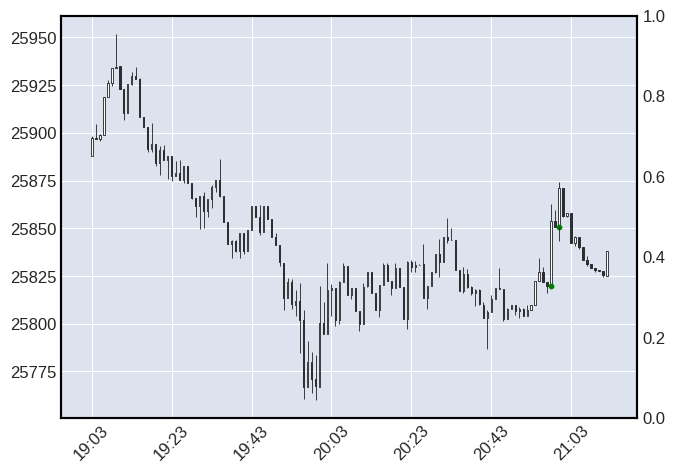

In [ ]:
import zenbt.zbt as zbt
from zenbt.data import get_sample_btc_data
import pandas as pd
import mplfinance as mpf
import talib

df = get_sample_btc_data()
df = df[120:250]

window = 50


ind = zbt.indicators.indicator_123(
    window,
    df["high"].to_numpy(),
    df["low"].to_numpy(),
    talib.MAX(df["high"], window).to_numpy(),
    talib.MIN(df["low"].to_numpy(), window),
)
df = df.to_pandas()
df["dates"] = pd.to_datetime(df["time"], unit="ms")
df.set_index("dates", inplace=True)

# tmin = talib.MIN(df['low'].to_numpy(), window)
# tmax = talib.MAX(df['high'].to_numpy(), window)


# # Apply the mask to determine where to display points
points_1 = df["open"].where(
    ind["point_1"]
)  # Keep 'Close' where mask is True, NaN otherwise
points_2 = df["close"].where(
    ind["point_2"]
)  # Keep 'Close' where mask is True, NaN otherwise
points_3 = df["low"].where(
    ind["point_3"]
)  # Keep 'Close' where mask is True, NaN otherwise
# points_4 = df['high'].where(ind['order_values'])  # Keep 'Close' where mask is True, NaN otherwise
add_plot = [
    mpf.make_addplot(points_1, type="scatter", markersize=10, color="green"),
    mpf.make_addplot(points_2, type="scatter", markersize=10, color="red"),
    mpf.make_addplot(points_3, type="scatter", markersize=10, color="blue"),
    # mpf.make_addplot(tmax, type='scatter', markersize=10, color='blue'),
    # mpf.make_addplot(tmin, type='scatter', markersize=10, color='blue'),
    mpf.make_addplot(ind["order_values"], type="scatter", markersize=10, color="lime"),
    mpf.make_addplot(ind["sl_values"], type="scatter", markersize=10, color="red"),
]

mpf.plot(
    df,
    type="candle",
    volume=False,
    title="Candlestick with Moving Averages",
    addplot=add_plot,
)